## Introduction

Defining things in relation to one another is an often overlooked but pervasive trait that we as people do. Of the available data structures, the best at capturing these relationships is a graph structure. Graph structured data is abundant--one need not look far to notice graphs in chemistry or social media--despite this however, only recently have deep learning approaches been adapted to take full advantage of graphs. These deep learning techniques fall into the umbrella of Graph Neural Networks (GNNs), a general framework where node features are aggregated based on the graph representation of the data towards an end goal. Due to the aforementioned abundance of graph structured data, GNNs and their variations are used in a wide range of disciplines: traffic prediction, recommender systems, drug discovery, structure learning, knowledge graphs and more. At the most basic level, GNN tasks include making predictions on different parts of the graph, or predicting the existence of links. 

This report aims to explore these basic applications of GNNs, focusing on a couple key aspects. First, we will inspect the common GNN architecture to highlight how it takes advantage of relational data. Then, we perform an analysis of a graph dataset, followed by the training and validation of a GNN for graph level predictions.

# GNN Architecture
Underpinning the effectiveness of GNNs ability to take advantage of relational data is the process by which features are aggregated using the graph representation of the data. This process is commonly referred to as message passing, wherein individual graph features such as nodes or edges pass ‘messages’ to their neighbors to update representations from one layer to another. Importantly, message passing operations must be permutation invariant to preserve graph symmetries. Some basic message passing operations include sum, mean, variance or maximum functions. Message passing with the mean aggregation operation is dubbed the graph convolutional network, or GCN . Mathematically, sum and mean message passing can be represented as a series of matrix operations. Given an undirected graph, $G = (A, H)$, where $A$ is the graph adjacency matrix, $H$ is the node feature matrix, $D$ is the node degree matrix, and $W$ an update function--usually a neural network--the new node feature matrix with the sum function can be found via $H^{l+1} = AH^{l}W$, and similarly for the mean function can be found via $H^{l+1} = AD^{-1}H^{l}W$. Below we can see an example of messages being calculated for a small graph with the mean aggregation function.

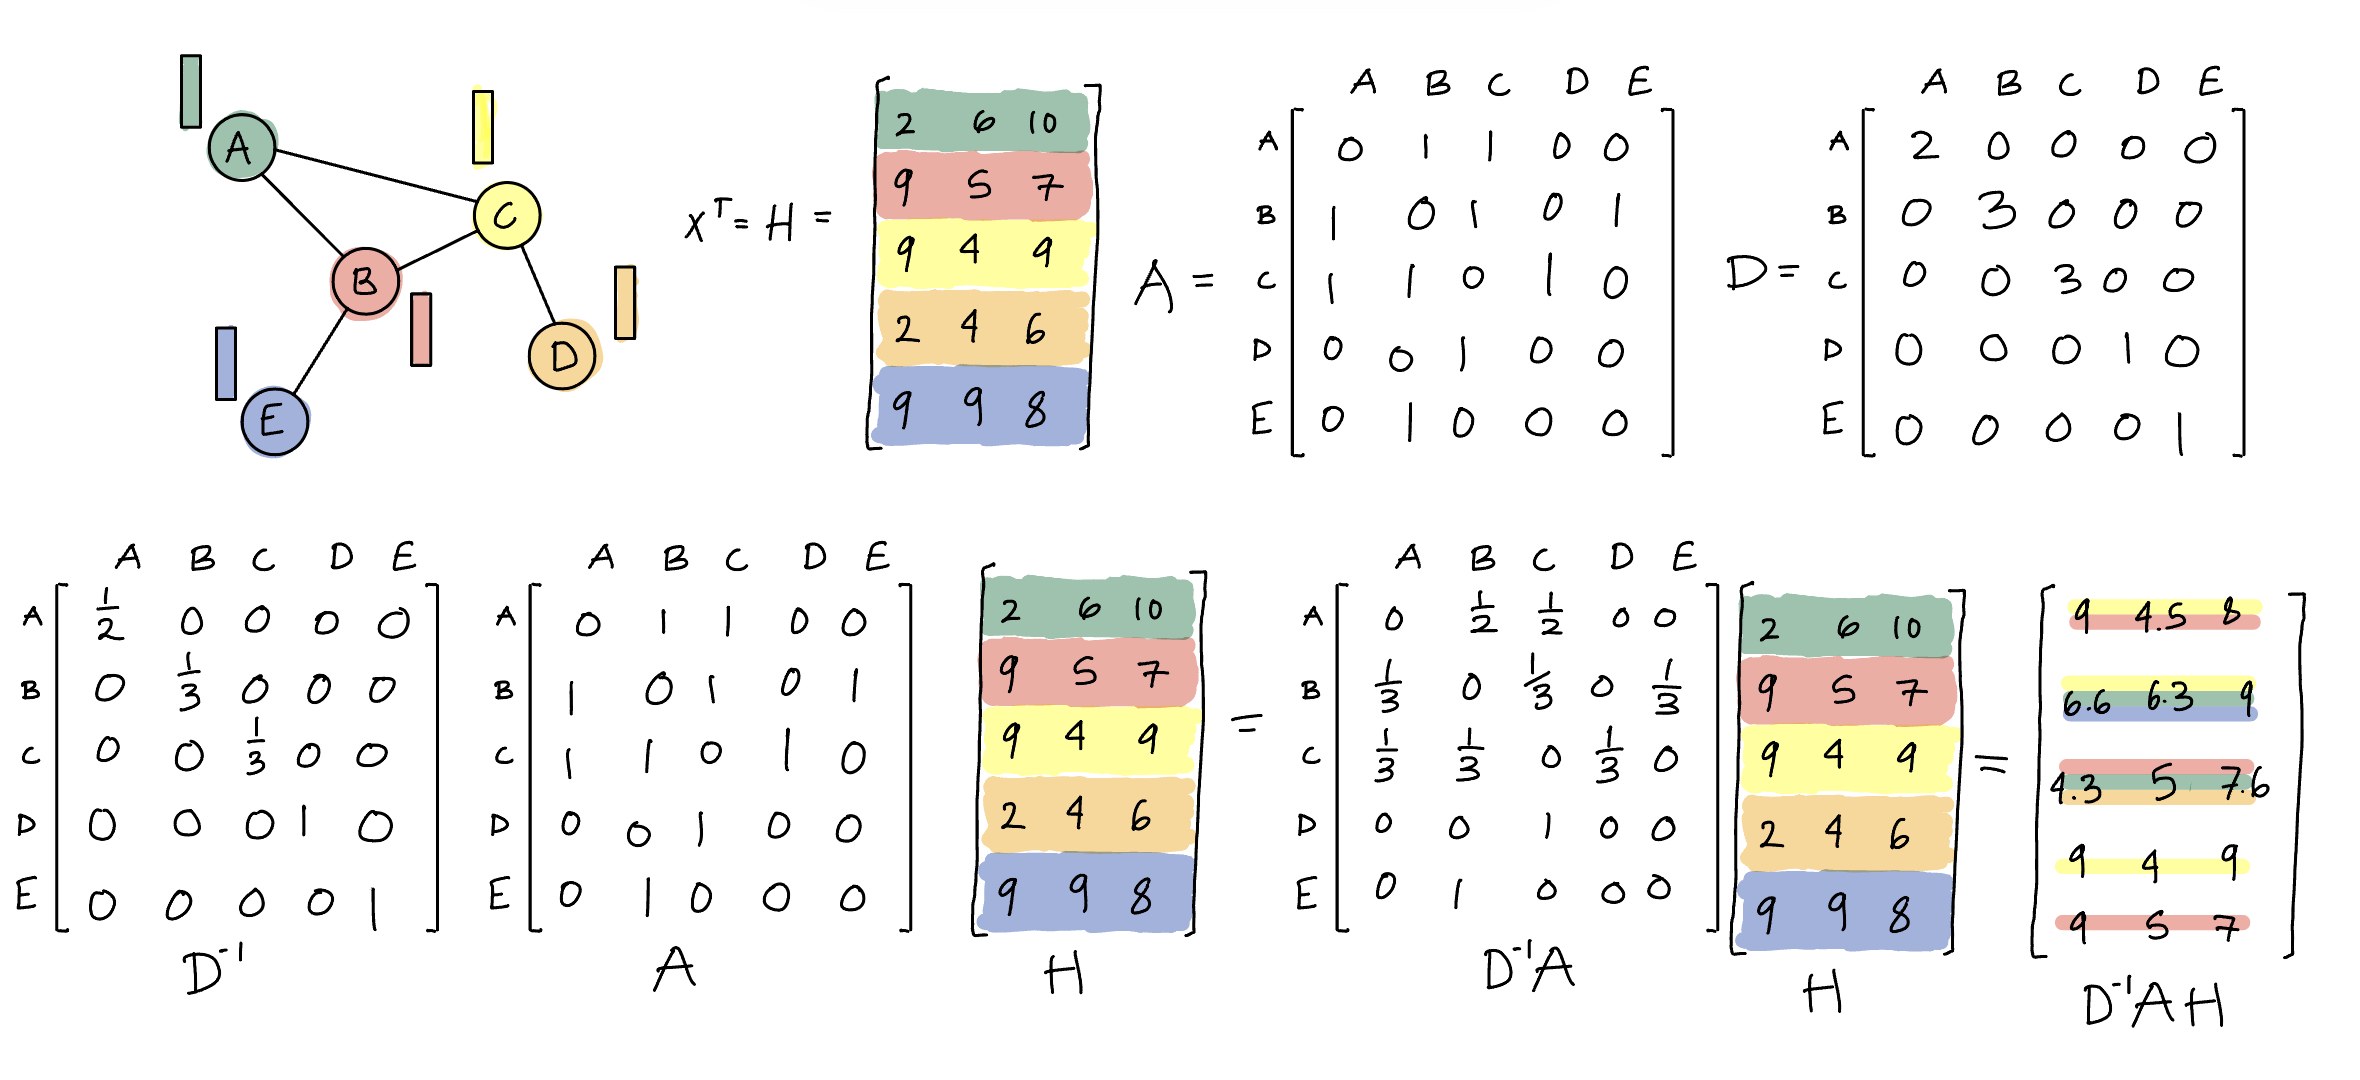

While effective, GNN architectures can suffer from both standard and GNN specific deep learning problems. Common deep learning problems such as vanishing/exploding gradients or overfitting can be dealt with like other models by introducing normalization and regularization. However, graph specific issues like oversmoothing and scalability require special considerations. Oversmoothing is the issue where node features start to become the same across the graph and is caused by performing message passing too many times. Problems of oversmoothing can be addressed by using skip-connections where node features from earlier layers are reintroduced in later ones. Skip connections are also used in other deep learning architectures including recurrent and convolutional neural networks. Additionally, graphs can become very large causing challenges towards scalability. Effectively handling this constraint requires the use of graph sampling techniques such as random neighborhood sampling or random walks.


## GNN Design Pipeline
Designing a GNN requires understanding of the graph structure being operated on, establishment of a task and loss function, and decisions regarding computational modules. 

Understanding the graph structure requires us to first find it, and then specify its type and scale. Depending on the data, finding graph structure can be split into structural and non-structural cases. Structural cases are those in which a graph structure is already explicit, i.e. applications on molecules, physical systems or knowledge graphs. Non-structural cases are those in which a graph structure is implicit, requiring us to build a graph. Some examples of non-structural cases include building a scene graph for an image or a connected 'word' graph for text. Once the graphs structure has been found we must determine its type: edges can either be directed or undirected, nodes and edges can either be heterogeneous or homogeneous and graph structure may be dynamic or static.

With an understanding of our graph, we can move on to determining a task and loss function. Tasks as touched on briefly in the introduction include prediction on different graph elements such as nodes or edges, and link prediction. Similarly to other deep learning architectures, loss functions such as categorical cross entropy or mean square error can be used for classification and regression respectively.

Finally, we follow up with initial decisions regarding computational modules that take advantage of the graph based on our new understanding. For example we may want to use edge weights and pool information between different elements of our graph, or determine node features from those stored in edges.

# Case Study: Molecular Property Prediction

For our case study we will see how a GNN can be applied to chemical property prediction of molecules, namely, if a compound can inhibit HIV replication. From Open Graph Benchmark (OGB) we will be using the ogbg-molhiv dataset, which is comprised of molecules gathered from MoleculeNet. Starting off we'll follow the GNN design pipeline before implementing, testing and making improvements to the proposed model.

In [1]:
# Initial imports.
import torch_geometric
import torch
import pandas as pd
import numpy as np

# Dataset imports.
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader

# Download and process data, setting up a train loader for EDA.
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')
split_idx = dataset.get_idx_split() 
train,valid,test = dataset[split_idx["train"]], dataset[split_idx["valid"]], dataset[split_idx["test"]]
train_loader = DataLoader(train, batch_size=32, shuffle=True)

## Analysis of Graph Structure
Following the first step of our design pipeline, we begin an analysis of our graph data. PyTorch Geometric (PyG) doesn't have functions to help visualize graphs so we'll be relying on NetworkX and PyG's to_networkx function to get a brief view of one of our graphs. 

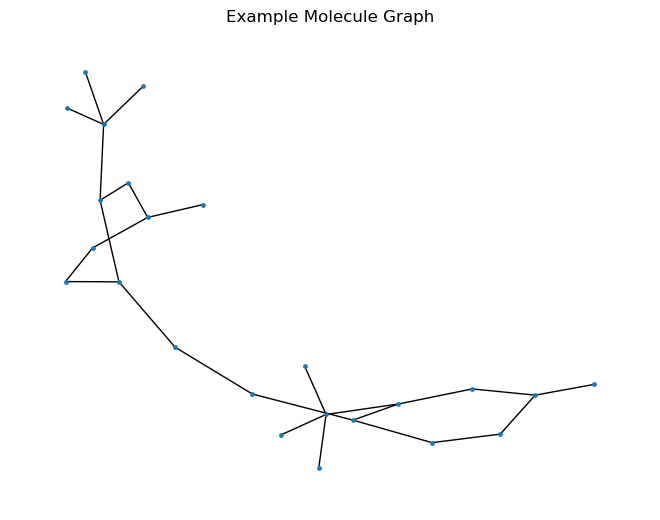

In [2]:
# Initial EDA imports.
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain an example graph.
example_nx = to_networkx(train[0], to_undirected=train[0].is_undirected()) 
nx.draw(example_nx, node_size=6)
plt.title('Example Molecule Graph');

### Graph Features
According to the datasets description on the [Open Graph Benchmark GitHub](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py), the molecular graphs include both edge and node features, giving us a degree of flexibility when we determine our computational modules. Moving on, nodes themselves include the following features: atomic number, chirality, degree, formal charge, numH, number of radical_e, hybridization, is aromatic and is in ring. Edges are more simple, and only include features describing bond type, bond stereo and if the bond is conjugated. Regardless of features, we will be using separate atom and bond encoders to create embeddings as recommended on OGB.

### Understanding Graph Type
Recalling our design pipeline, we can move on to describing properties about our graphs in order to design the model. Here we would consider the graph structure explicit, given that molecules themselves are graphs. Given that edges will always represent bonds and nodes atoms, our graph is considered homogenous. Lastly, per the dataset, our graphs are both static and undirected. 

### Determining a Task and Loss
Since it is our goal to determine if a molecule can inhibit HIV replication or not, it's clear that our task falls into binary classification. Following standard procedure across other deep learning fields, we'll use binary cross entropy. For testing, we'll refer to the AUC metric.



### Choosing Computational Modules 
While our dataset includes node and edge features, we'll keep our initial model simple. In doing so, we'll test a model that uses the GCN described above. To make our model work towards graph level predictions, we'll pool the final node feature outputs together and use a linear classifier to make a prediction. After our initial exploration, we can improve the model with edge features. 

### Summarizing Steps
In summary, we know that our molecular graphs are structured, homogeneous, undirected and static. We know that they contain edge and node features. We know that our model will train and evaluate with binary cross-entropy and AUC respectively. And we know that our initial model will use mean aggregation before performing pooling and making a prediction.

## Setting Up Our Model


### Defining the Model
In PyG we set up our model as a subclass of the torch.nn.Module, allowing it to calculate gradients and giving it easy access to other torch.nn.Module objects if necessary. As mentioned previously, our first model will be defined with aggregation functions for nodes before combining features with global pooling to make a final prediction.


In [3]:
from torch_geometric.nn import GraphConv, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# Set up a model subclassing the torch.nn.Module class so autograd works.
class MolModel(torch.nn.Module):

    def __init__(self, hidden_channels : int, aggr : str):
        # In the init function we initialize the torch.nn.Module class and set up GNN layers, an atom encoder and classifier.
        super().__init__()

        self.conv1 = GraphConv(hidden_channels, 200, aggr)
        self.conv2 = GraphConv(200, 150, aggr)
        self.classifier = torch.nn.Linear(150, 2)
        self.atom_encoder = AtomEncoder(hidden_channels)
    
    def forward(self, node_features : torch.Tensor , edge_index : torch.Tensor, batch):
        # Apply the atom encoder to our node features.
        node_features = self.atom_encoder(node_features)

        # Pass updated features through convolutional layers using ReLU.
        node_features = self.conv1(node_features, edge_index)
        node_features = node_features.relu()
        node_features = self.conv2(node_features, edge_index)
        node_features = node_features.relu()
        
        # Use global add pooling on the features to obtain a graph feature.
        pooled_features = global_add_pool(node_features, batch=batch)

        # Put features through the classifier to obtain logits.
        logits = self.classifier(pooled_features)
        
        # Return logits from model.
        return logits

### Training Our Model
Now with an initial model defined we can train and then evaluate it. Starting with encoding graph node features we run a loop over our training loader. Then, using the Adam optimizer and binary cross entropy loss function, we set up our model to train.

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
from ogb.graphproppred import Evaluator

# Set up an evaluator and a list to store evaluation data.
evaluator = Evaluator(name = 'ogbg-molhiv')  
eval_data=[]

# Use a batch size of 512 due to the datasets imbalance.
train_loader = DataLoader(train, batch_size=512, shuffle=True)

# Set up a test loader to get auc scores during evaluation.
test_loader = DataLoader(test, batch_size=32, shuffle=True)

# Set up the model on the device. cuda:0 here since my GPU at home uses that alias.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Iterate over possible atom dimensions.
for atom_dim in [100, 200, 300, 400]:

    # Set up an initial model with mean aggregation and the atom dimension.
    initial_model = MolModel(atom_dim, 'mean')
    # Send the model to the device.
    model = initial_model.to(device)
    # Create an optimzer, here we set up Adam with a learning rate of 0.01 and the models parameters.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train across 15 epochs.
    for epoch in range(0, 15):
        total_loss = total_examples = 0

        # Iterate over the sampled data in the train loader.
        for sampled_data in train_loader:
            # Clear the gradient.
            optimizer.zero_grad()

            # Send the data to the device.
            sampled_data.to(device)

            # Get a prediction from the model.
            pred = model(sampled_data.x, sampled_data.edge_index, sampled_data.batch)

            # Get the ground truth edge labels from the sampled data.
            ground_truth = sampled_data.y.squeeze(1)

            # Calculate the loss using cross_entropy. 
            loss = F.cross_entropy(pred, ground_truth)

            # Send the loss backwards through the model.
            loss.backward()

            # Step the optimizer forward.
            optimizer.step()
            
            # Add loss to continuing calculations.
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()

        y_pred, y_true = [], []
        # Iterate over the graphs.
        for sampled_data in test_loader:
            # Send data to the device.
            sampled_data.to(device)
            
            # Get true values along with output logits, detach values from device if gpu and send to cpu.
            y_true.append(sampled_data.y.squeeze(1).detach().cpu())
            logits = model(sampled_data.x, sampled_data.edge_index, sampled_data.batch)
            y_pred.append(F.softmax(logits.detach().cpu(),dim=1)[:, 1])

        # Get the predictions and true labels into acceptable format.    
        y_pred = torch.cat(y_pred, dim=0).numpy()
        y_true = torch.cat(y_true, dim=0).numpy()

        # Obtian the AUC score and append metrics to the list.
        acc = evaluator.eval({'y_true': y_true.reshape(len(y_true),1), 'y_pred': y_pred.reshape(len(y_true),1)})
        eval_data.append([epoch, total_loss / total_examples, atom_dim, acc['rocauc']])
# Create a dataframe from the stored metrics for graphing.
eval_data = pd.DataFrame(eval_data, columns=['epoch', 'loss', 'atom_dim', 'auc'])

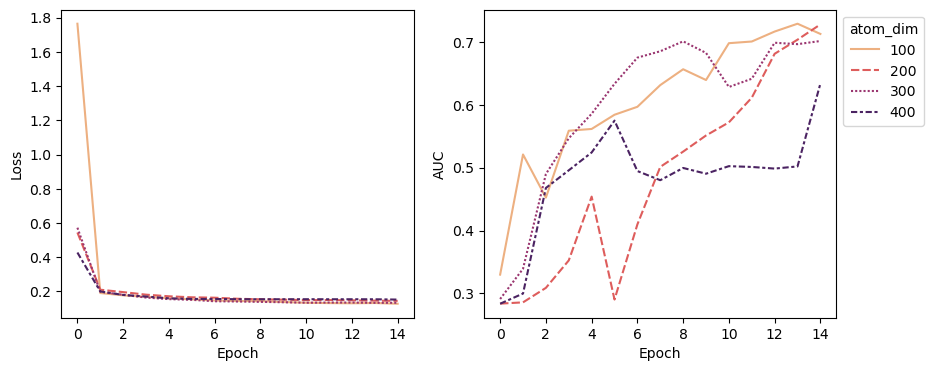

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
g = sns.lineplot(eval_data, x='epoch', y='loss', hue='atom_dim', style='atom_dim', ax=axs[0], palette='flare', legend=False)
g.set_ylabel('Loss')
g.set_xlabel('Epoch')
f = sns.lineplot(eval_data, x='epoch', y='auc', hue='atom_dim', style='atom_dim', ax=axs[1], palette='flare')
sns.move_legend(f, "upper left", bbox_to_anchor=(1, 1))
f.set_ylabel('AUC')
f.set_xlabel('Epoch');

If we examine our loss graph, atom dimensions higher than 100 all start with a much lower loss and all start to converge after the first epoch. Despite this convergence, the AUC score generally improves as epochs continue. Seemingly, atom embedding dimensions of 100 lead to the highest AUC, however at the 14th epoch an embedding dimension of 400 starts to climb drastically.

### Utilizing Edge Features
Also included in our dataset are collections of edge features, which can be added to our model with a variety of available layers in PyG. Here we'll use graph attention network layers, known as GATConv in PyG. Similar to our atom features, we will be encoding edge features with an edge encoder.

In [9]:
from torch_geometric.nn import GATConv

# Set up a new model using the GATConv layer.
class GatMolModel(torch.nn.Module):

    def __init__(self, encoder_channels : int, aggr : str):
        # In the init function we initialize the torch.nn.Module class and set up GNN layers, an atom encoder and classifier.
        super().__init__()

        self.conv1 = GATConv(in_channels=encoder_channels, out_channels=200, aggr=aggr, edge_dim=encoder_channels)
        self.conv2 = GATConv(in_channels=200, out_channels=150, aggr=aggr, edge_dim=encoder_channels)
        self.classifier = torch.nn.Linear(150, 2)
        self.atom_encoder = AtomEncoder(encoder_channels)
        self.bond_encoder = BondEncoder(encoder_channels)
    
    def forward(self, node_features : torch.Tensor , edge_index : torch.Tensor, edge_features : torch.Tensor, batch):
        # Apply the atom encoder to our node features.
        node_features = self.atom_encoder(node_features)
        edge_features = self.bond_encoder(edge_features)

        # Pass updated features through convolutional layers using ReLU.
        node_features = self.conv1(node_features, edge_index, edge_features)
        node_features = node_features.relu()
        node_features = self.conv2(node_features, edge_index, edge_features)
        node_features = node_features.relu()
        
        # Use global add pooling on the features to obtain a graph feature.
        pooled_features = global_add_pool(node_features, batch=batch)

        # Put features through the classifier to obtain logits.
        logits = self.classifier(pooled_features)
        
        # Return logits from model.
        return logits

In [10]:
# Set up a list to store gat evaluation data.
gat_eval_data=[]

# Set up the model on the device. cuda:0 here since my GPU at home uses that alias.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Iterate over possible atom dimensions.
for atom_dim in [100, 200, 300, 400]:

    # Set up an initial model with mean aggregation and send the model to the device.
    gat_model = GatMolModel(atom_dim, 'mean').to(device)

    # Create an optimzer, here we set up Adam with a learning rate of 0.01 and the models parameters.
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

    # Train across 15 epochs.
    for epoch in range(0, 15):

        total_loss = total_examples = 0
        gat_model.train()
        # Iterate over the sampled data in the train loader.
        for sampled_data in train_loader:
            # Clear the gradient.
            optimizer.zero_grad()

            # Send the data to the device.
            sampled_data.to(device)

            # Get a prediction from the model.
            pred = gat_model(sampled_data.x, sampled_data.edge_index, sampled_data.edge_attr, sampled_data.batch)

            # Get the ground truth edge labels from the sampled data.
            ground_truth = sampled_data.y.squeeze(1)

            # Calculate the loss using cross_entropy. 
            loss = F.cross_entropy(pred, ground_truth)

            # Send the loss backwards through the model.
            loss.backward()

            # Step the optimizer forward.
            optimizer.step()
            
            # Add loss to continuing calculations.
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()

        y_pred, y_true = [], []
        # Iterate over the graphs.
        gat_model.eval()
        for sampled_data in test_loader:
            # Send data to the device.
            sampled_data.to(device)
            
            # Get true values along with output logits, detach values from device if gpu and send to cpu.
            y_true.append(sampled_data.y.squeeze(1).detach().cpu())
            logits = gat_model(sampled_data.x, sampled_data.edge_index, sampled_data.edge_attr, sampled_data.batch)
            y_pred.append(F.softmax(logits.detach().cpu(),dim=1)[:, 1])
            
        # Get the predictions and true labels into acceptable format.    
        y_pred = torch.cat(y_pred, dim=0).numpy()
        y_true = torch.cat(y_true, dim=0).numpy()
        
        # Obtian the AUC score and append metrics to the list.
        acc = evaluator.eval({'y_true': y_true.reshape(len(y_true),1), 'y_pred': y_pred.reshape(len(y_true),1)})
        gat_eval_data.append([epoch, total_loss / total_examples, atom_dim, acc['rocauc']])

# Create a dataframe with the GAT model data.
gat_eval_data = pd.DataFrame(gat_eval_data, columns=['epoch', 'loss', 'atom_dim', 'auc'])

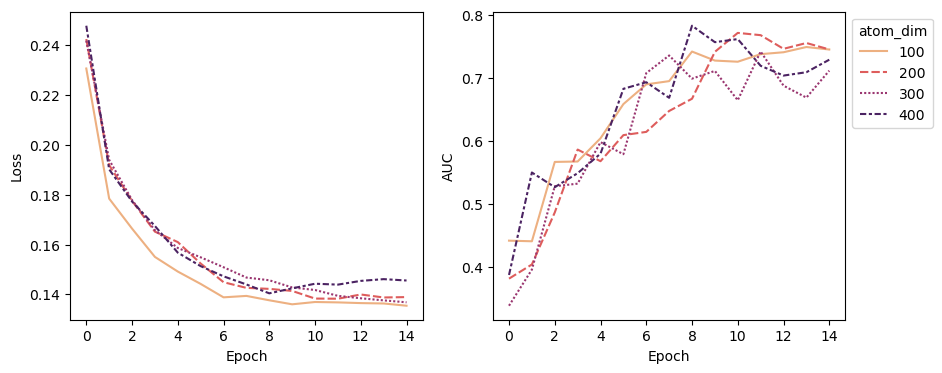

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
g = sns.lineplot(gat_eval_data, x='epoch', y='loss', hue='atom_dim', style='atom_dim', ax=axs[0], palette='flare', legend=False)
g.set_ylabel('Loss')
g.set_xlabel('Epoch')
f = sns.lineplot(gat_eval_data, x='epoch', y='auc', hue='atom_dim', style='atom_dim', ax=axs[1], palette='flare')
sns.move_legend(f, "upper left", bbox_to_anchor=(1, 1))
f.set_ylabel('AUC')
f.set_xlabel('Epoch');

Compared to the previous model, losses across embedding dimensions all start in relatively simple places with an embedding dimension of 100 becoming the smallest. Similarly to the previous model, even though loss starts to converge repeated epochs improve the AUC score. Here however, our AUC score not only reaches a higher point but it does so earlier and with a larger embedding dimension.   

# Quarter in Review
In review, this quarter saw me immersing myself in new and challenging material. Starting with a deep dive into available literature, I began the quarter focusing on learning about deep learning, GNNs and introducing myself to probabilistic graphical modeling. Continuing readings but at a slower pace, I then implemented a neural network and GNN in NumPy. Despite challenges, implementing these foundational models helped me understand their inner workings and learn how to diagnose potential issues when using other deep learning libraries. From this point, I began to focus on learning how to apply a GNN towards improving structure learning techniques. After reading through PyG documentation, I learned about link prediction tasks and tried my hand at a model. Due to its low performance I took a step back and began examining properties of the estimated covariance and inverse covariance matrix. During which I attempted to learn how to better quantify the existence of an edge based off of node feature dot products. With a better understanding of the data and some new ideas, I then took a short break to apply what I've learned towards the case study included above.